# Machine Learning in Python - Group Project 2

**Due Friday, April 14th by 16.00 pm.**

Em Belanger, Alex Chen, Richelle Lee Wirharjanto, Robin Lin

## General Setup

In [ ]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Seasonal stats stuff
from statsmodels.tsa.seasonal import seasonal_decompose

# Preprocessing, classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

from scipy.stats import ttest_ind

In [ ]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

In [ ]:
# Load data
d = pd.read_csv("hotel.csv")

In [ ]:
d.head()

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,Resort Hotel,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0
1,0,Resort Hotel,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0
2,0,Resort Hotel,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0
3,0,Resort Hotel,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0
4,0,Resort Hotel,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1


## 1. Introduction

Cancellations of hotel bookings are costly to hotels, as it can be hard to fill empty rooms at the last minute. Our goal is to build a model that can accurately predict whether a hotel booking will be cancelled or not, given certain features of the booking.

The data used for this analysis is sourced from the Hotel Booking Demand dataset. This dataset contains information on hotel bookings made in two hotels: a resort hotel and a city hotel. The dataset includes information such as booking dates, room types, meal options, and customer demographics. The data spans over a period of two years, from July 2015 to August 2017. This dataset has been used to train our model.

We explore the cancellation patterns of a hotel and identify key factors that contribute to cancellations including lead time, total cost of stay, and the number of required car parking spaces. Our analysis shows that cancellations are more likely to occur for bookings made through online travel agencies, for bookings with shorter lead times, and for booking smade during specific seasons. Additionally, the number of previous cancellations made by a customer is a strong predictor of whether they will cancel their reservation in the future.

We consider Logistic Regression, Random Forest and Decision Tree Classifier in this report to build our prediction model. We begin our analysis by exploring the data to better understand the dataset, followed by preprocessing and data cleaning to ensure high-quality inputs to the models. Next we train several models, optimizing their parameters and measuring their performance using various metrics, including accuracy, precision, recall, and F1-score. Using these criteria we select the best model out of those considered.

Our analysis finds that it is possible to predict hotel cancellations with a high degree of accuracy. We achieve an accuracy of 87% in our final model, with a recall for cancellations of 89%, which means that out of the cancellations in our data our model predicts 89% of them to be cancellations. The precision rate is 79% for cancellations, meaning that from the cases where a cancellation is predicted, around 79% of cases are actually cancelled.

Based on our findings, we suggest that hotels should prioritize the number of rooms sold over the revenue earned from each room. It is also important for hotels to provide sufficient facilities to satisfy possible special requests from guests, as this is a significant factor in guest satisfaction and retention. Hotels should also consider making deposits refundable, as this may help to reduce cancellations.

Furthermore, we advise that hotels should be cautious when releasing their room vacancies too early, as guests are more likely to cancel a reservation when they book too far in advance.

## 2. Exploratory Data Analysis and Feature Engineering

We begin the exploratory analysis and feature engineering with some data cleaning, and we follow with visualisations. We conduct feature engineering in both the cleaning and visualisation stages of the exploration.

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

There are several columns related to date, we chose to focus on the week number because it is easy to interpret and the time interval is not too small to lose the generalisability. In contrast `arrival_date_day_of_month` should be combined with `arrival_date_month` to make both variables meaningful. It is also better to set `arrival_date_year` and `arrival_date_week_number` as categorical variables because we cannot explain the linear changes within these two variables (and we cannot generalise to the values outside the scope).

In [ ]:
d.drop(['arrival_date_month', 'arrival_date_day_of_month'], axis=1, inplace=True)

In [ ]:
d.arrival_date_week_number = d.arrival_date_week_number.astype('category')
d.arrival_date_year = d.arrival_date_year.astype('category')

In [ ]:
d.hotel.unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

There are only two kinds of hotel, and we are interested in the cancel rate for two hotel types, so we set it as a categorical variable.

In [ ]:
d.hotel = d.hotel.astype('category')

We also set `is_canceled`, `meal`, `market_segment`, `distribution_channel`, `is_repeated_guest`, `reserved_room_type`, `assigned_room_type`, `deposit_type`, `customer_type` as categorical variables for better interpretation.

In [ ]:
d.is_canceled = d.is_canceled.astype('category')
d.meal = d.meal.astype('category')
d.market_segment = d.market_segment.astype('category')
d.distribution_channel = d.distribution_channel.astype('category')
d.is_repeated_guest = d.is_repeated_guest.astype('category')
d.reserved_room_type = d.reserved_room_type.astype('category')
d.assigned_room_type = d.assigned_room_type.astype('category')
d.deposit_type = d.deposit_type.astype('category')
d.customer_type = d.customer_type.astype('category')

We want our model to be unbiased and to not be discriminatory, so we did not include the variable `country`.

In [ ]:
d.drop(['country'], axis=1, inplace=True)

For simplicity, we used `previous_cancel_rate` to represent `previous_cancellations` and `previous_bookings_not_canceled`.

In [ ]:
d['previous_cancel_rate'] = d.loc[:,['previous_cancellations', 'previous_bookings_not_canceled']]\
                            .apply(lambda x: x[0]/(x[0]+x[1]) if (x[0]+x[1]) != 0 else 0, axis=1)

In [ ]:
d.drop(['previous_cancellations', 'previous_bookings_not_canceled'], axis=1, inplace=True)

Checking the columns with N/A in the dataset.

In [ ]:
d.columns[d.isna().any()]

Index(['children', 'agent', 'company'], dtype='object')

Now we deal with missing values. The first features with missing values are `agent` and `company`, we think that the values with N/A represent individual travelers (making/paying the booking by themselves), and we denote them as 0 and set them as categorical variables.

In [ ]:
d.agent = d.agent.fillna(0)
## Change to int to avoid flotating numbers, then change to categorical
d.agent = d.agent.astype(int).astype('category')

d.company = d.company.fillna(0)
## Change to int to avoid flotating numbers, then change to categorical
d.company = d.company.astype(int).astype('category')

After the procedures above, now we only have one column with missing values, `children`. We assumed that it means that there are no children in that booking record, so we set the missing values to 0.

In [ ]:
d.children = d.children.fillna(0).astype(int)

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   is_canceled                  119390 non-null  category
 1   hotel                        119390 non-null  category
 2   lead_time                    119390 non-null  int64   
 3   arrival_date_year            119390 non-null  category
 4   arrival_date_week_number     119390 non-null  category
 5   stays_in_weekend_nights      119390 non-null  int64   
 6   stays_in_week_nights         119390 non-null  int64   
 7   adults                       119390 non-null  int64   
 8   children                     119390 non-null  int64   
 9   babies                       119390 non-null  int64   
 10  meal                         119390 non-null  category
 11  market_segment               119390 non-null  category
 12  distribution_channel         119390 non-null

In [ ]:
d.describe()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,previous_cancel_rate
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,104.011416,0.927599,2.500302,1.856403,0.103886,0.007949,0.221124,2.321149,101.831122,0.062518,0.571363,0.050180
std,106.863097,0.998613,1.908286,0.579261,0.398555,0.097436,0.652306,17.594721,50.535790,0.245291,0.792798,0.216513
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000,0.000000
50%,69.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000,0.000000
75%,160.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,0.000000
max,737.000000,19.000000,50.000000,55.000000,10.000000,10.000000,21.000000,391.000000,5400.000000,8.000000,5.000000,1.000000


In [ ]:
for i in d.columns[d.dtypes == 'category']:
    print(d[i].unique())

[0, 1]
Categories (2, int64): [0, 1]
['Resort Hotel', 'City Hotel']
Categories (2, object): ['City Hotel', 'Resort Hotel']
[2015, 2016, 2017]
Categories (3, int64): [2015, 2016, 2017]
[27, 28, 29, 30, 31, ..., 22, 23, 24, 25, 26]
Length: 53
Categories (53, int64): [1, 2, 3, 4, ..., 50, 51, 52, 53]
['BB', 'FB', 'HB', 'SC', 'Undefined']
Categories (5, object): ['BB', 'FB', 'HB', 'SC', 'Undefined']
['Direct', 'Corporate', 'Online TA', 'Offline TA/TO', 'Complementary', 'Groups', 'Undefined', 'Aviation']
Categories (8, object): ['Aviation', 'Complementary', 'Corporate', 'Direct', 'Groups', 'Offline TA/TO', 'Online TA', 'Undefined']
['Direct', 'Corporate', 'TA/TO', 'Undefined', 'GDS']
Categories (5, object): ['Corporate', 'Direct', 'GDS', 'TA/TO', 'Undefined']
[0, 1]
Categories (2, int64): [0, 1]
['C', 'A', 'D', 'E', 'G', 'F', 'H', 'L', 'P', 'B']
Categories (10, object): ['A', 'B', 'C', 'D', ..., 'G', 'H', 'L', 'P']
['C', 'A', 'D', 'E', 'G', ..., 'B', 'H', 'P', 'L', 'K']
Length: 12
Categorie

From the summary table, the continuous data are all reasonable, even though there are some large values. For the categorical data, we also fail to find counterintuitive values. That being said, there is only one booking with a negative adr. We think it is impossible for the average daily rate to be negative in this case, especially because there is only one case with a negative value. We decided to remove this row on the basis that the value does not seem possible, and is likely due to a recording error.

In [ ]:
d[d.adr < 0]

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,previous_cancel_rate
14969,0,Resort Hotel,195,2017,10,4,6,2,0,0,...,2,No Deposit,273,0,0,Transient-Party,-6.38,0,0,0.0


In [ ]:
d = d[d.adr >= 0]

In [ ]:
d.columns

Index(['is_canceled', 'hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'agent', 'company', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'previous_cancel_rate'],
      dtype='object')

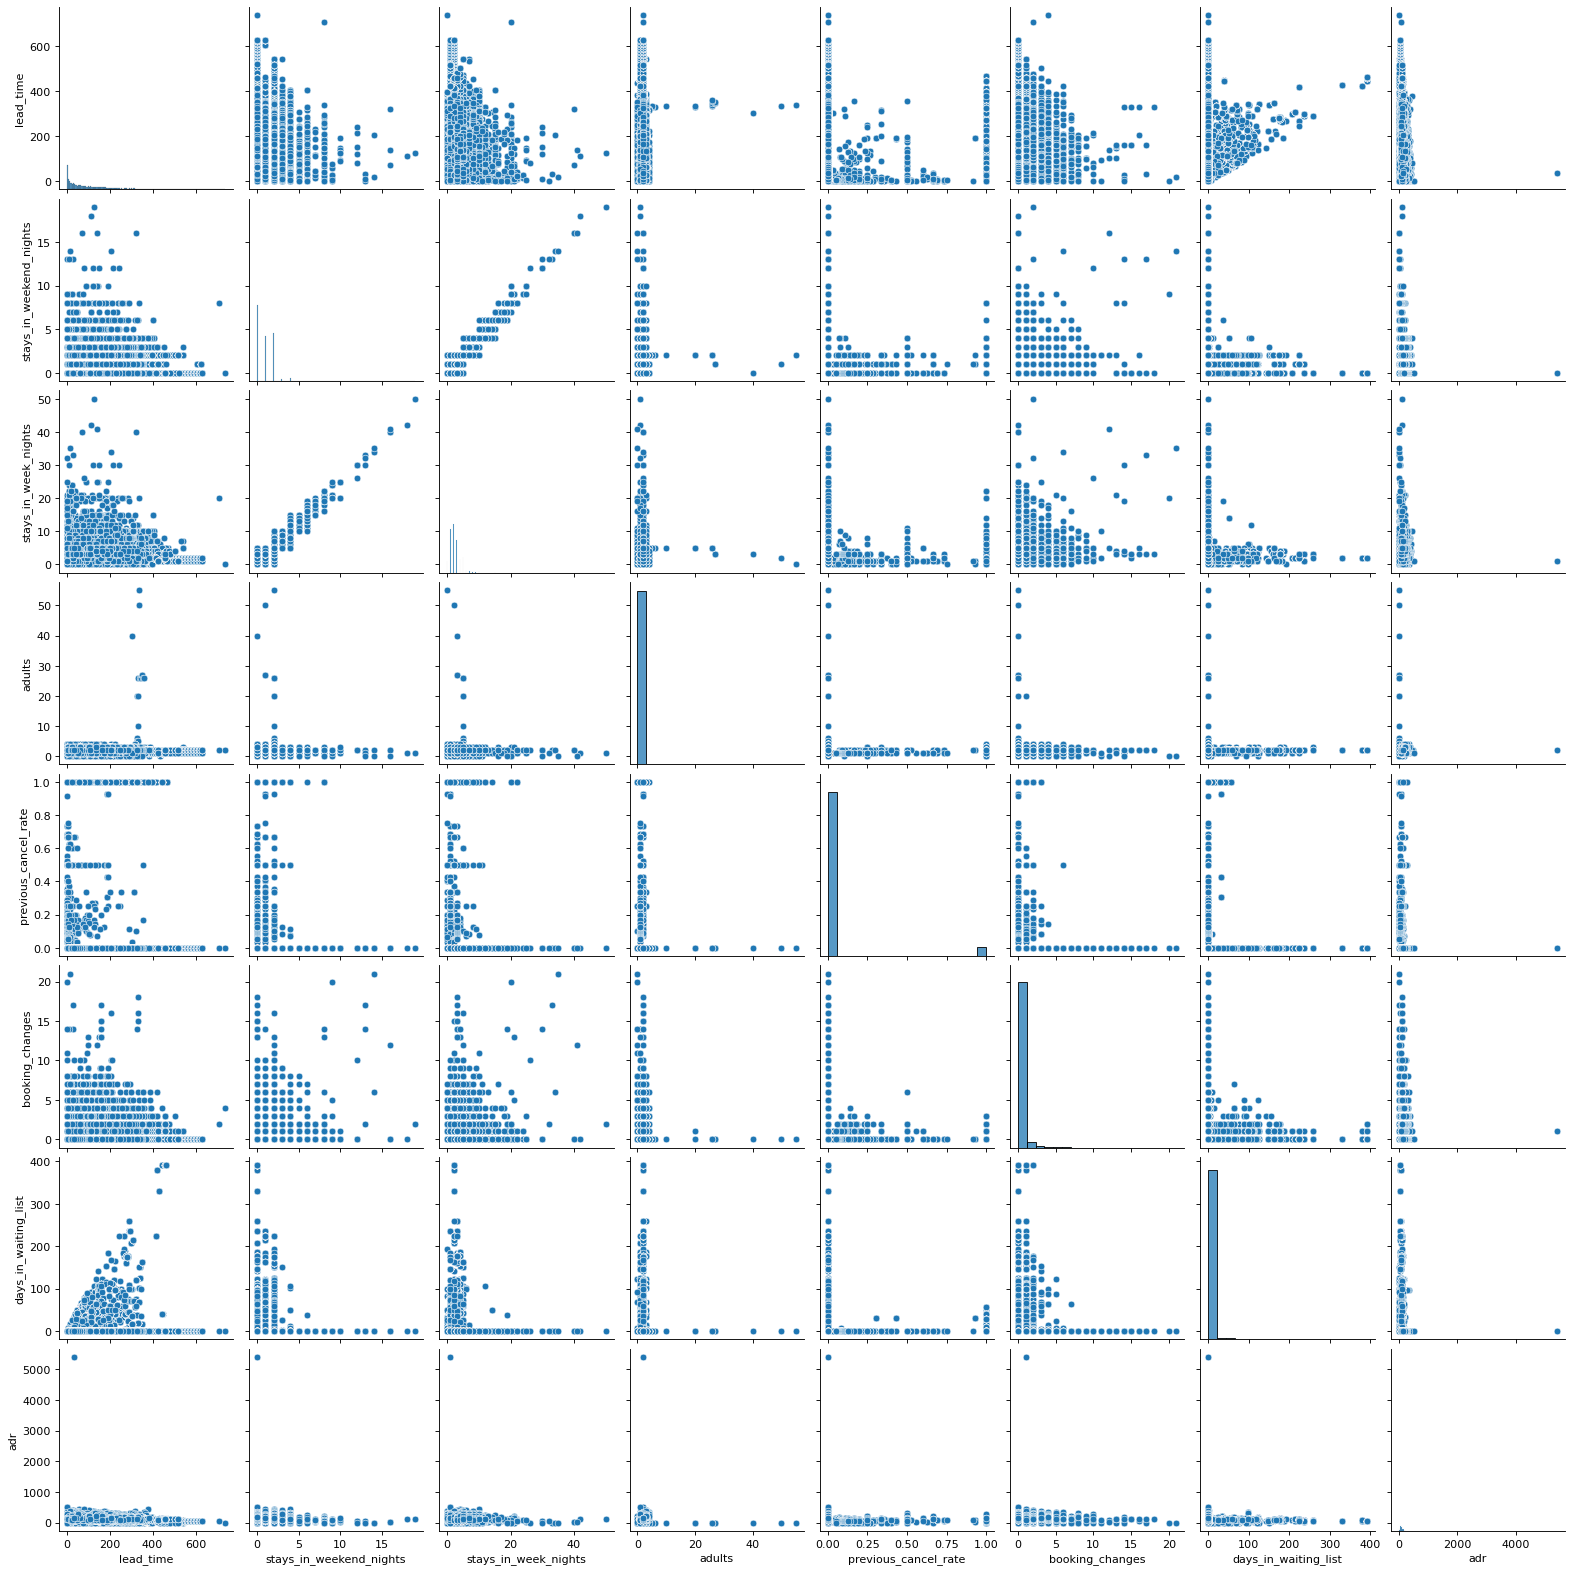

In [ ]:
sns.pairplot(data = d.loc[:, ['lead_time',
       'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'previous_cancel_rate', 
       'booking_changes', 'days_in_waiting_list', 'adr']])

There are some variables which seem highly correlated: `stays_in_weekend_nights` & `stays_in_week_nights`, `days_in_waiting_list` & `lead_time`, `lead_time` & `booking_changes`, `stays_in_weekend_nights` & `booking_changes`, `stays_in_week_nights` & `booking_changes`, `booking_changes` & `days_in_waiting_list`, `booking_changes` & `previous_cancel_rate`. 

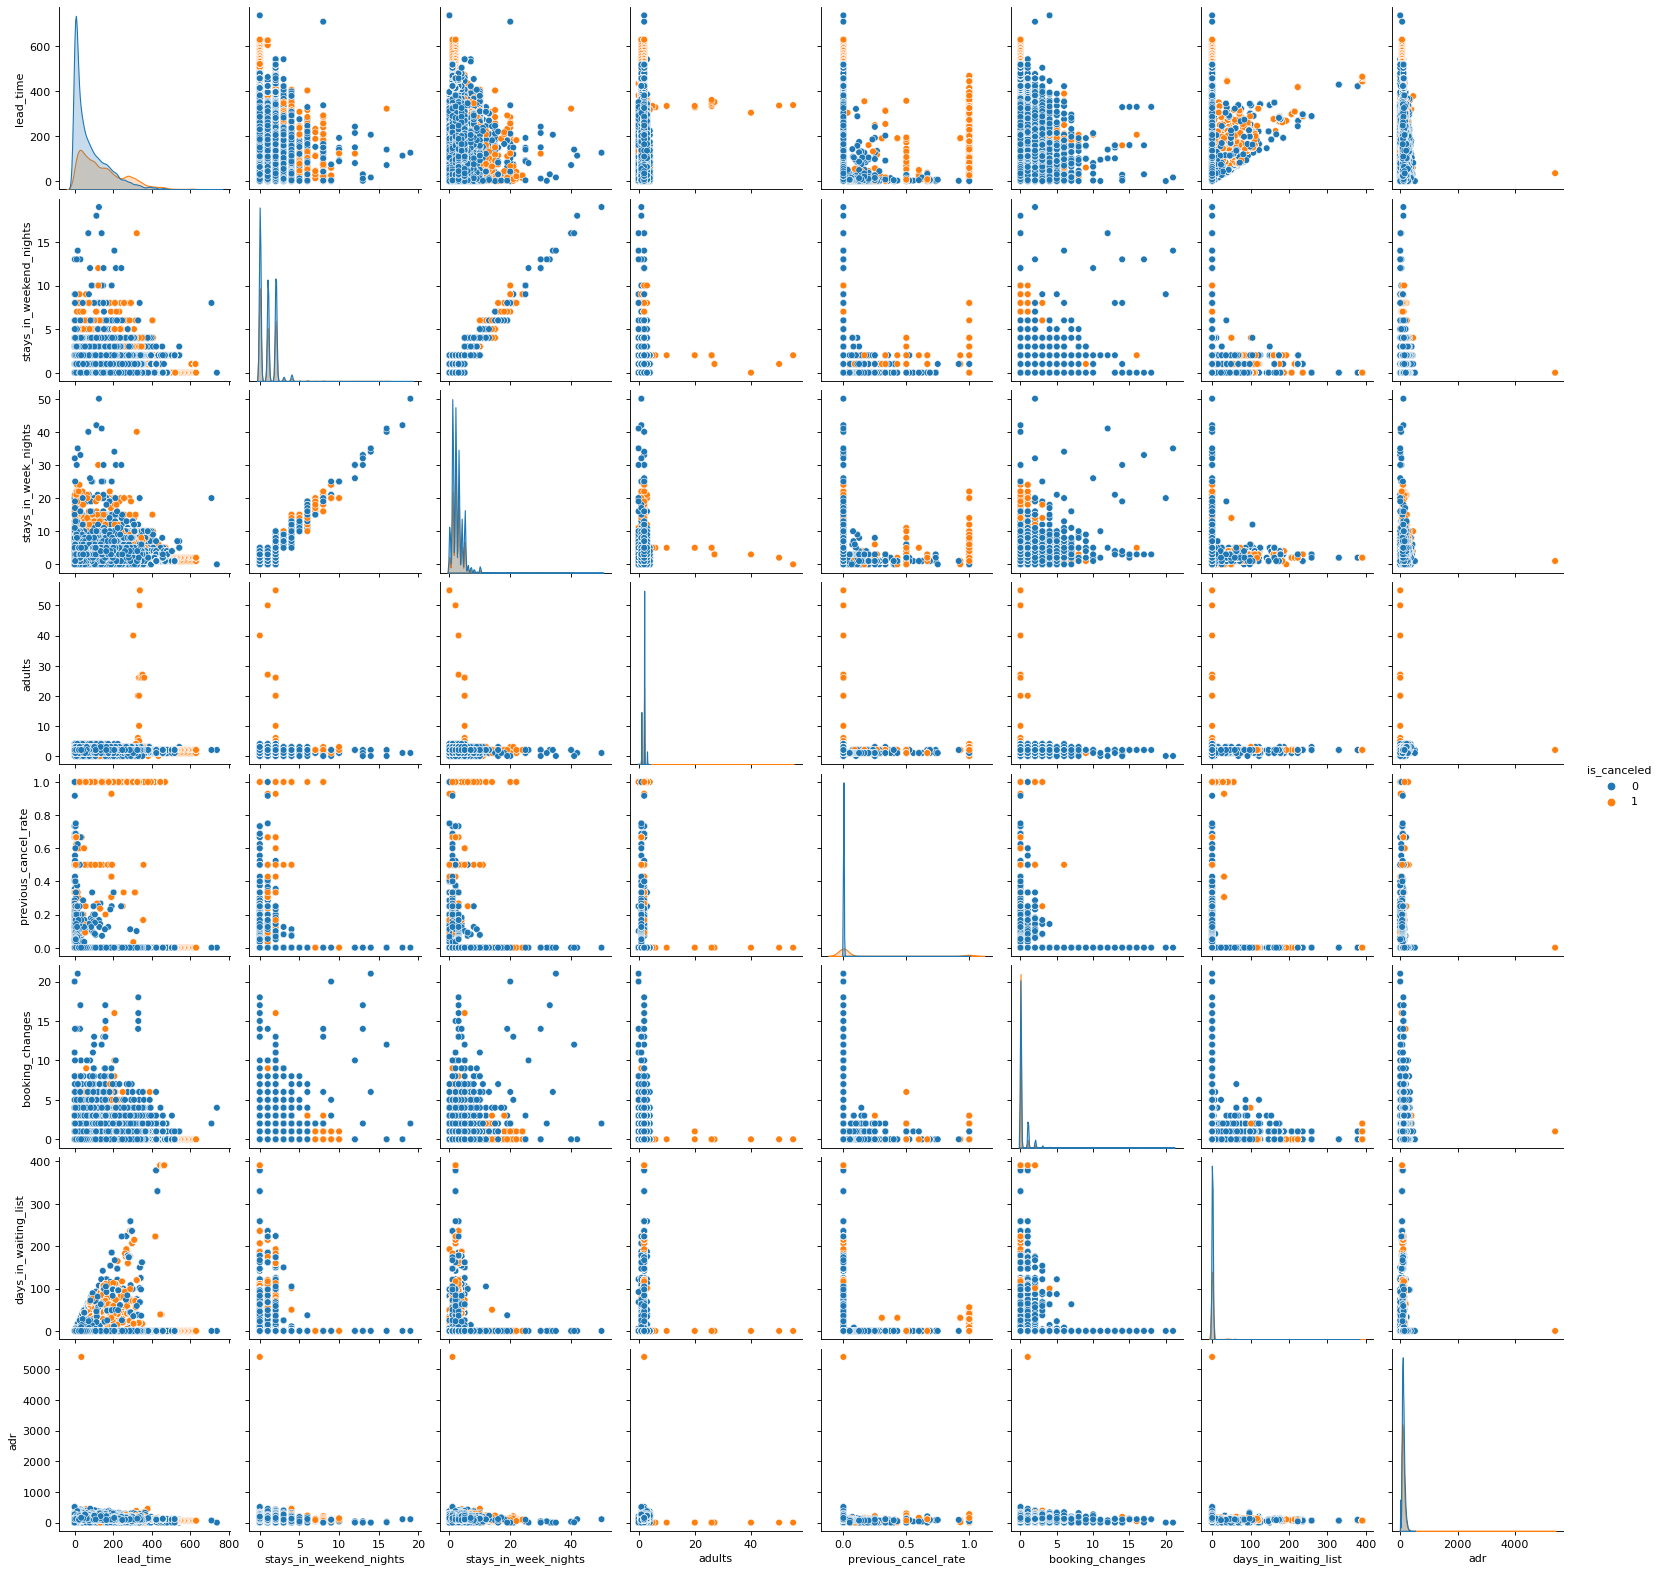

In [ ]:
sns.pairplot(data = d.loc[:, ['lead_time',
       'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'previous_cancel_rate', 
       'booking_changes', 'days_in_waiting_list', 'adr', "is_canceled"]], hue = "is_canceled")

From the above pairplots, which are stratified by cancellation status, we do not see strong distinctions in the distributions of variables for cancelled vs not cancelled bookings. We see some evidence of interactions affecting cancellations, such as `stays_in_week_nights` and `lead_time`, however none of the interactions are very strong. We do not see evidence that any fo the features need to be transformed.

We now look for relationships between cancellations and week number.

[Text(0.5, 1.0, 'Rolling Average Cancel Rate'),
 Text(0, 0.5, 'Rolling Average Cancel Rate'),
 Text(0.5, 0, 'Week Number')]

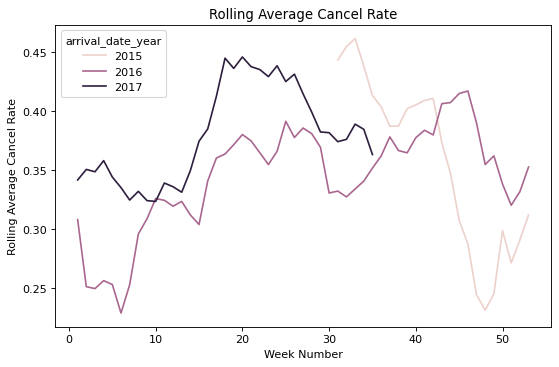

In [ ]:
## Make sum of cancelled/not cancelled by week number and year, plot the line plot!
temp = d.copy()
temp.is_canceled = d.is_canceled.astype(int)
temp.arrival_date_year = d.arrival_date_year.astype(int)
temp.arrival_date_week_number = d.arrival_date_week_number.astype(int)


count_cancel = temp.groupby(by = ['arrival_date_year', 'arrival_date_week_number'], 
                            as_index = False).mean()

## Calculate rolling average to smooth the data and better show patterns.
count_cancel["cancel_rate_ma"] = count_cancel["is_canceled"].rolling(window = 5).mean()

sns.lineplot(data = count_cancel, x = "arrival_date_week_number", 
             y = "cancel_rate_ma", hue = "arrival_date_year").set(title = "Rolling Average Cancel Rate", 
                                                                  ylabel = "Rolling Average Cancel Rate", 
                                                                  xlabel = "Week Number")

In order to show relationships between the cancellation rate and week number we used a rolling average to smooth the data, as the raw time series data had sharp fluctuations.

The data collection begins approximately halfway through the year 2015, and ends approximately halfway through the year 2017. We can see that for both 2016 and 2017 there is a lower cancellation rate at the begining of the year, and higher cancellation rate starting from approximately week 15. Looking at 2015 and 2016 we can see that earlier in the year the cancellation rate seems higher, and towards the end of the year it appears to go down.

The above plot gives us some evidence that including seasonality in our model may be useful.

Next we look at the number of cancellations for each week.

[Text(0.5, 1.0, 'Rolling Average Cancel Rate'),
 Text(0, 0.5, 'Rolling Average Cancel Rate'),
 Text(0.5, 0, 'Week Number')]

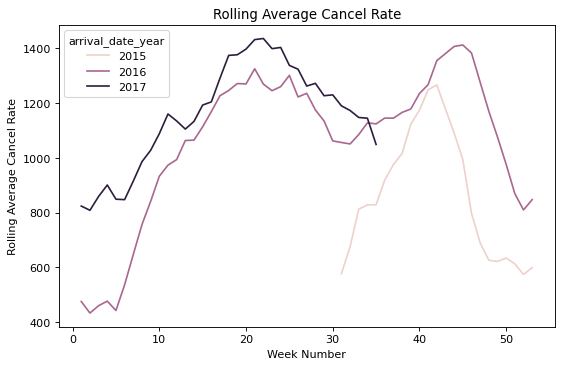

In [ ]:
count_cancel = temp.groupby(by = ['arrival_date_year', 'arrival_date_week_number'], 
                            as_index = False).count()

count_cancel["cancel_rate_ma"] = count_cancel["is_canceled"].rolling(window = 5).mean()

sns.lineplot(data = count_cancel, x = "arrival_date_week_number", 
             y = "cancel_rate_ma", hue = "arrival_date_year").set(title = "Rolling Average Cancel Rate", 
                                                                  ylabel = "Rolling Average Cancel Rate", xlabel = "Week Number")

Once again we used a rolling average to smooth the time series data. From this plot we see evidence again of seasonality in the cancellations. We also conduct a time series decomposition of the data to show trends, including seaosnality.

In [ ]:
temp_count_cancel = count_cancel.dropna(axis=0).reset_index()
temp_count_cancel.index = pd.date_range("20150727", periods=111, freq="W")

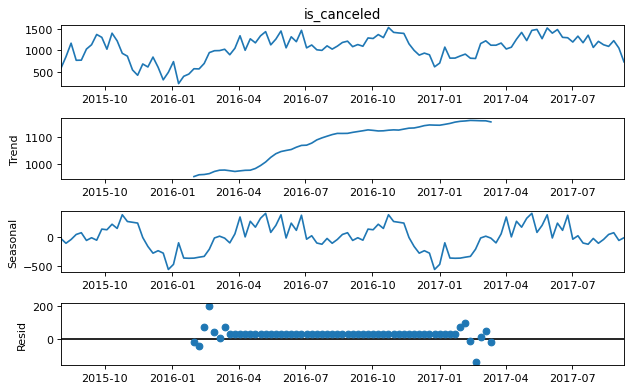

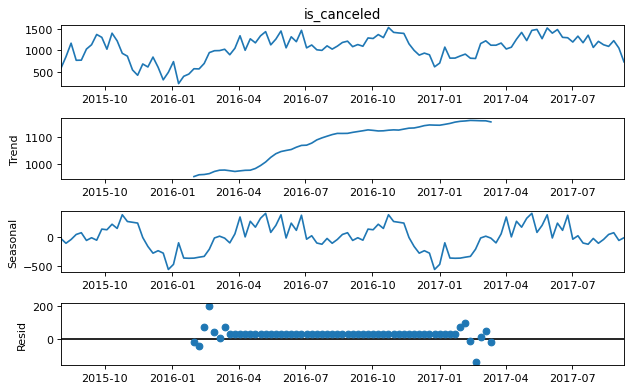

In [ ]:
results = seasonal_decompose(temp_count_cancel.is_canceled)
results.plot()

The above decomposition shows an overall increase in cancellations over time, and also seasonal behaviour of cancellations which we observed in the previous plots. From this evidence we decided to create dummy variable to denote different seasons.

To determine the endpoints of each season we used cancellation rate rolling average. We inspected the plot of the rolling average cancellation rate and chose points which lay outside of the peaks and troughs we observed for each season. We then found the minumum and maximum values of these points for both years, and took an average of the points to select an endpoint date.

In [ ]:
## Ensure we are working with the correct verion of the data (the version which includes cancellation rate)
temp = d.copy()
temp.is_canceled = d.is_canceled.astype(int)
temp.arrival_date_year = d.arrival_date_year.astype(int)
temp.arrival_date_week_number = d.arrival_date_week_number.astype(int)


count_cancel = temp.groupby(by = ['arrival_date_year', 'arrival_date_week_number'], 
                            as_index = False).mean()

## Calculate rolling average to smooth the data and better show patterns.
count_cancel["cancel_rate_ma"] = count_cancel["is_canceled"].rolling(window = 5).mean()

In [ ]:
## Seasonal point 1: week 1 to week 22
## Years 2017 and 2016

min2017 = count_cancel.loc[(count_cancel["arrival_date_week_number"] < 22) & (count_cancel["arrival_date_year"] == 2017)].cancel_rate_ma.min()
min2016 = count_cancel.loc[(count_cancel["arrival_date_week_number"] < 22) & (count_cancel["arrival_date_year"] == 2016)].cancel_rate_ma.min()

week2016min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2017min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2017) & (count_cancel["arrival_date_year"] == 2017)]["arrival_date_week_number"]

print(week2016min)
print(week2017min)

max2017 = count_cancel.loc[(count_cancel["arrival_date_week_number"] < 22) & (count_cancel["arrival_date_year"] == 2017)].cancel_rate_ma.max()
max2016 = count_cancel.loc[(count_cancel["arrival_date_week_number"] < 22) & (count_cancel["arrival_date_year"] == 2016)].cancel_rate_ma.max()

week2016max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2017max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2017) & (count_cancel["arrival_date_year"] == 2017)]["arrival_date_week_number"]

print(week2016max)
print(week2017max)
print((8 + 20)/2)

sea_point1 = 14


32    6
Name: arrival_date_week_number, dtype: int64
89    10
Name: arrival_date_week_number, dtype: int64
46    20
Name: arrival_date_week_number, dtype: int64
99    20
Name: arrival_date_week_number, dtype: int64
14.0


In [ ]:
## Seasonal point 2: week 20 to end of 2017 (35)
## Use 2016 and 2017 only due to lack of overlap with 2015

#count_cancel.loc[count_cancel["arrival_date_year"] == 2017].arrival_date_week_number.max()

min2017 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2017) & (count_cancel["arrival_date_week_number"] < 35) & (count_cancel["arrival_date_week_number"] > 20)].cancel_rate_ma.min()
min2016 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2016) & (count_cancel["arrival_date_week_number"] < 35) & (count_cancel["arrival_date_week_number"] > 20)].cancel_rate_ma.min()

week2016min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2017min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2017) & (count_cancel["arrival_date_year"] == 2017)]["arrival_date_week_number"]

print(week2016min)
print(week2017min)

max2017 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2017) & (count_cancel["arrival_date_week_number"] < 35) & (count_cancel["arrival_date_week_number"] > 20)].cancel_rate_ma.max()
max2016 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2016) & (count_cancel["arrival_date_week_number"] < 35) & (count_cancel["arrival_date_week_number"] > 20)].cancel_rate_ma.max()

week2016max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2017max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2017) & (count_cancel["arrival_date_year"] == 2017)]["arrival_date_week_number"]

print(week2016max)
print(week2017max)

print((31.5 + 24.5)/2)
sea_point2 = 28

58    32
Name: arrival_date_week_number, dtype: int64
110    31
Name: arrival_date_week_number, dtype: int64
51    25
Name: arrival_date_week_number, dtype: int64
103    24
Name: arrival_date_week_number, dtype: int64
28.0


In [ ]:
## Seasonal point 3: week 31 to 43

min2015 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2015) & (count_cancel["arrival_date_week_number"] < 43) & (count_cancel["arrival_date_week_number"] > 31)].cancel_rate_ma.min()
min2016 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2016) & (count_cancel["arrival_date_week_number"] < 43) & (count_cancel["arrival_date_week_number"] > 31)].cancel_rate_ma.min()

week2016min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2015min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2015) & (count_cancel["arrival_date_year"] == 2015)]["arrival_date_week_number"]

print(week2016min)
print(week2015min)

max2015 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2015) & (count_cancel["arrival_date_week_number"] < 43) & (count_cancel["arrival_date_week_number"] > 31)].cancel_rate_ma.max()
max2016 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2016) & (count_cancel["arrival_date_week_number"] < 43) & (count_cancel["arrival_date_week_number"] > 31)].cancel_rate_ma.max()

week2016max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2015max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2015) & (count_cancel["arrival_date_year"] == 2015)]["arrival_date_week_number"]

print(week2016max)
print(week2015max)

print((35 + 37)/2)

sea_point3 = 36

58    32
Name: arrival_date_week_number, dtype: int64
11    38
Name: arrival_date_week_number, dtype: int64
67    41
Name: arrival_date_week_number, dtype: int64
6    33
Name: arrival_date_week_number, dtype: int64
36.0


In [ ]:
## Seasonal point 4: week 37 to the end (53)
## Years 2016 and 2015

#count_cancel["arrival_date_week_number"].max()

min2015 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2015) & (count_cancel["arrival_date_week_number"] < 53) & (count_cancel["arrival_date_week_number"] > 37)].cancel_rate_ma.min()
min2016 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2016) & (count_cancel["arrival_date_week_number"] < 53) & (count_cancel["arrival_date_week_number"] > 37)].cancel_rate_ma.min()

week2016min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2015min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2015) & (count_cancel["arrival_date_year"] == 2015)]["arrival_date_week_number"]

print(week2016min)
print(week2015min)

max2015 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2015) & (count_cancel["arrival_date_week_number"] < 53) & (count_cancel["arrival_date_week_number"] > 37)].cancel_rate_ma.max()
max2016 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2016) & (count_cancel["arrival_date_week_number"] < 53) & (count_cancel["arrival_date_week_number"] > 37)].cancel_rate_ma.max()

week2016max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2015max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2015) & (count_cancel["arrival_date_year"] == 2015)]["arrival_date_week_number"]

print(week2016max)
print(week2015max)

print((51 + 48 + 46 + 42)/4)

sea_point4 = 47

77    51
Name: arrival_date_week_number, dtype: int64
21    48
Name: arrival_date_week_number, dtype: int64
72    46
Name: arrival_date_week_number, dtype: int64
15    42
Name: arrival_date_week_number, dtype: int64
46.75


In [ ]:
d.arrival_date_week_number = d.arrival_date_week_number.astype(int)


In [ ]:
d["season"] = 0

d.loc[d["arrival_date_week_number"] < sea_point1, "season"] = 1
d.loc[d["arrival_date_week_number"] >= sea_point4, "season"] = 1
d.loc[(d["arrival_date_week_number"] >= sea_point1) & (d["arrival_date_week_number"] < sea_point2), "season"] = 2
d.loc[(d["arrival_date_week_number"] >= sea_point2) & (d["arrival_date_week_number"] < sea_point3), "season"] = 3
d.loc[(d["arrival_date_week_number"] >= sea_point3) & (d["arrival_date_week_number"] < sea_point4), "season"] = 4

d.season = d.season.astype("category")
d.arrival_date_week_number = d.arrival_date_week_number.astype("category")
d.head()

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,previous_cancel_rate,season
0,0,Resort Hotel,342,2015,27,0,0,2,0,0,...,No Deposit,0,0,0,Transient,0.0,0,0,0.0,2
1,0,Resort Hotel,737,2015,27,0,0,2,0,0,...,No Deposit,0,0,0,Transient,0.0,0,0,0.0,2
2,0,Resort Hotel,7,2015,27,0,1,1,0,0,...,No Deposit,0,0,0,Transient,75.0,0,0,0.0,2
3,0,Resort Hotel,13,2015,27,0,1,1,0,0,...,No Deposit,304,0,0,Transient,75.0,0,0,0.0,2
4,0,Resort Hotel,14,2015,27,0,2,2,0,0,...,No Deposit,240,0,0,Transient,98.0,0,1,0.0,2


Now we visualise some categorical variables using bar plots.

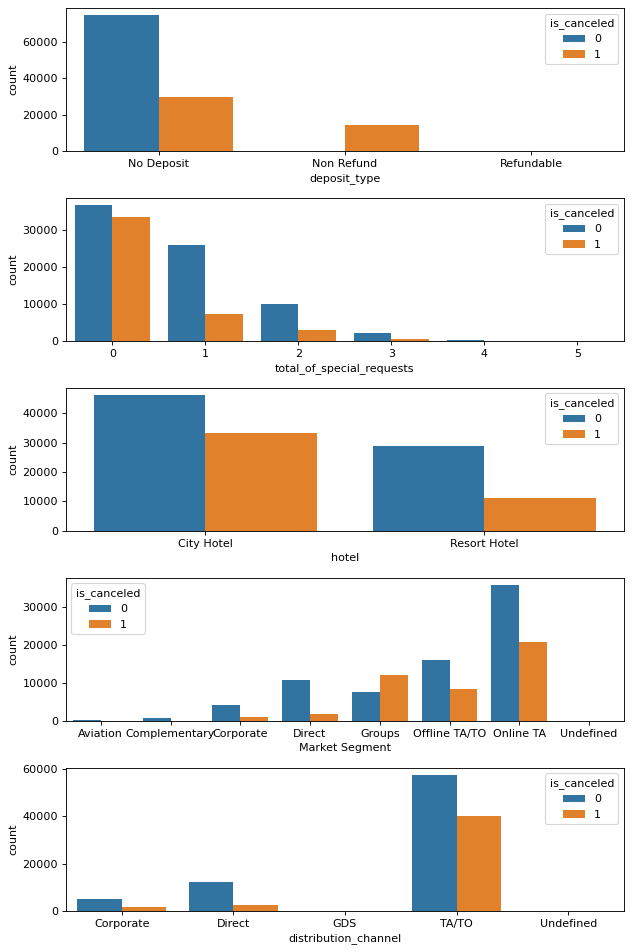

In [ ]:
## Alter figure size so it's easier to read plots
plt.rcParams['figure.figsize'] = (8,12)

fig, axs = plt.subplots(ncols=1, nrows = 5)

sns.countplot(x = d["deposit_type"], hue = d["is_canceled"], ax = axs[0])
sns.countplot(x = d["total_of_special_requests"], hue = d["is_canceled"], ax = axs[1])
sns.countplot(x = d["hotel"], hue = d["is_canceled"], ax = axs[2])
sns.countplot(x = d["market_segment"], hue = d["is_canceled"], ax = axs[3]).set(xlabel = "Market Segment")

sns.countplot(x = d["distribution_channel"], hue = d["is_canceled"], ax = axs[4])


plt.tight_layout()

The non refund deposit type has the highest proportion of cancellations, which is unexpected. Almost all observations in this group are canceled (14,494 cancellations out of 14,587 observations total with this type).

The highest proportion of cancellations by far comes from customers with 0 special requests - which again may be due to the fact that this is the largest group in the special requests category. 

City hotels seem to have a higher proportion of cancelations compared to resort hotels. 

The group market segment has the highest proportion of cancelations - there are more cancelations than not canceled bookings in this group. 

Bookings made through travel agents have a higher cancellation rate than other types of bookings.

We did not observe any strong patterns in the data from bar plot analysis of the other categorical variables, so we elected to not include them in this report.

Due to the simplicity and interpretability, we chose to keep `season` instead of `arrival_date_week_number` to represent the time in an year. We also decided to not classify different agents and companies. Instead, we only kept the indicator whether an agent made a booking/a company paid a booking. In this case, because we impute 0 as individual customers (formerly missing values), we just needed to create an indicator checking whether a value is 0.

In [ ]:
d['by_agent'] = d.agent != 0
d['by_company'] = d.company != 0

In [ ]:
d_final = d.drop(['arrival_date_week_number', 'agent', 'company'], axis=1)

## 3. Model Fitting and Tuning

The objective of the research is to use an appropriate model to predict cancellations, and determine fcators which influence cancellation by guests. Hence the model should be interpretable, have strong predictive ability, and achieve a high recall rate. Among the machine learning models satisfying those three conditions we consider logistic regression, classification tree, and random forest. In this case the three models perform similarly. However, the random forest model took longer to execute, and taking into account the difficulty in interpreting the model, we wouldn't use it for our single final model. As for the logistic regression and classification tree, they have comparable results in terms of accuracy, and f-1 score. However, the decision tree is slightly better in terms of the recall rate, so we selected decision tree for further tuning.

In [ ]:
df_X = d_final.drop('is_canceled', axis = 1)

Some of the variables in the dataset must be transformed into the correct numeric format. Also it is important to standardise the values.

In [ ]:
df_X = pd.get_dummies(df_X, drop_first = True)

In [ ]:
y = d.is_canceled.values

We now split the dataset, using 80% of the data for training and 20% of the data for testing.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_X.values, y, random_state = 5, test_size = 0.2, stratify = y)

To find the optimal model, we selected three hyperparameters to tune: `criterion` (different spliting criteria may have different results), `max_depth`, and `min_samples_split` (to find the optimal value to prevent overfitting and strike a balance between performance and validation results).

In [ ]:
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
             'max_depth': [5, 10, 20, 50, 100],
             'min_samples_split': [2, 5, 10, 50]}

gs = GridSearchCV(DecisionTreeClassifier(random_state = 5, class_weight = "balanced"),
                 param_grid = param_grid, scoring = "recall", cv = 5)

In [ ]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=5),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10, 20, 50, 100],
                         'min_samples_split': [2, 5, 10, 50]},
             scoring='recall')

In [ ]:
gs.best_params_

{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10}

In [ ]:
gs.best_score_

0.8016055626244689

According the grid search, the best model can achieve a recall rate 80%, with the hyperparameters `criterion`: `gini`, `max_depth`: 20, `min_samples_split`: 10.

In [ ]:
y_pred = gs.best_estimator_.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     15033
           1       0.73      0.81      0.77      8845

    accuracy                           0.82     23878
   macro avg       0.80      0.81      0.81     23878
weighted avg       0.82      0.82      0.82     23878



/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


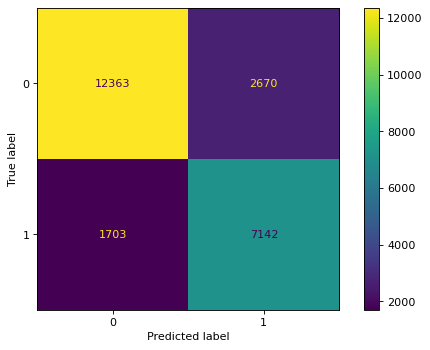

In [ ]:
## Reset plotting size
plt.rcParams['figure.figsize'] = (8,5)
plot_confusion_matrix(gs.best_estimator_, X_test, y_test)

Now we have used the testing data to predict the values. In summary, the recall rate is 81%, meaning that out of the cancellations in our testing data our model predicts 81% of them to be cancellations, which is similar to the training results, indicating there is no severe overfitting problem. The precision rate is 73%, meaning that from the cases where a cancellation is predicted, around 73% of cases are actually cancelled. The overall accuracy is 82%, which is quite high. From the confusion matrix, most of the cases are identified correctly, with only some of them being identified incorrectly. Specifically, among 8845 cancelation cases, only 1703 cancelations are not caught, compared to 7142 cases which are successful.

Now we are going to fit the final model in the next section.

## 4. Discussion & Conclusions


In [ ]:
model = gs.best_estimator_.fit(df_X.values, y)

In [ ]:
y_pred_final = model.predict(df_X.values)
print(classification_report(y, y_pred_final))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89     75165
           1       0.79      0.89      0.84     44224

    accuracy                           0.87    119389
   macro avg       0.86      0.88      0.87    119389
weighted avg       0.88      0.87      0.87    119389



/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


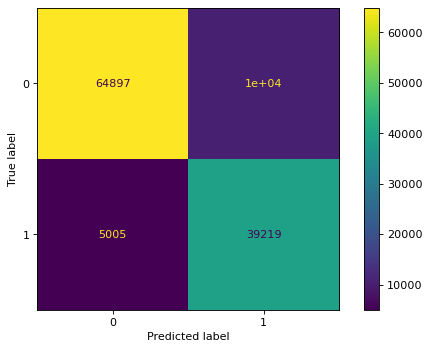

In [ ]:
plot_confusion_matrix(model, df_X.values, y)

For the final model, we used the complete data to fit the data with the optimal hyperparameters, and got the fitting results. In summary, the model can identify 89% of cancellation, and from all cases where a cancellation is predicted, there are around 79% of cases would actually be cancelled. The overall accuracy is 87%, which is quite high. From the confusion matrix, most of the cases are identified correctly, with only some of them being identified incorrectly. Generally speaking, the model is effective to predict the cancellation.

We also want to check the performance of the model is predicting that a booking will not be cancelled. 

In [ ]:
df_fi = pd.DataFrame({'Feature': df_X.columns, 'Importance': model.feature_importances_})

In [ ]:
df_fi[df_fi.Importance >= 0.05]

,Feature,Importance
0,lead_time,0.155406
8,adr,0.089315
10,total_of_special_requests,0.077363
11,previous_cancel_rate,0.068235
26,market_segment_Online TA,0.054055
53,deposit_type_Non Refund,0.292105


From the table above, we obtain that the most important factor resulting in a cancellation is the 'non-refundable' type of deposit. In addition, lead time and average daily rate are important for predicting the cancellation.

<AxesSubplot:xlabel='is_canceled', ylabel='lead_time'>

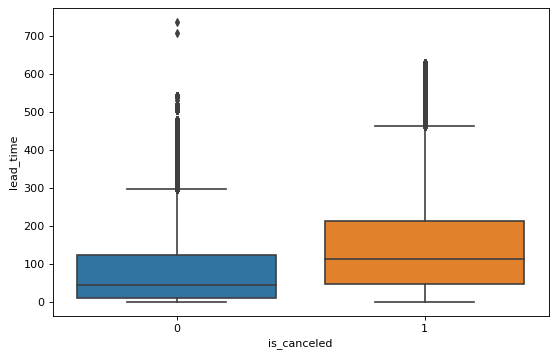

In [ ]:
sns.boxplot(x = 'is_canceled', y = 'lead_time', data = d_final)

From the box plot above, those with longer lead times tend to cancel their bookings. We can also check this using a t-test. The null hypothesis is $H_0$: the cancelled and non-cancelled groups have the same lead times. The alternative hypothesis is $H_1$: the cancelled and non-cancelled groups have different lead times.

In [ ]:
ttest_ind(d_final[d_final.is_canceled == 0].lead_time, d_final[d_final.is_canceled == 1].lead_time)

Ttest_indResult(statistic=-105.93723399330558, pvalue=0.0)

From the result, the p-value is close to 0, indicating that the statistic is significant. This means we reject the null hypothesis in favour of the alternative, that the lead times are different.

As for the influence of deposit type, in the previous section we already found that hotels with a non-refundable type of deposit are more likely to have their guests cancel their bookings. We can check the relationship between deposit type and cancellation using cancellation rate again.

In [ ]:
d_final_copy = d_final.copy()
d_final_copy['is_canceled'] = d_final_copy['is_canceled'].astype(int)
d_final_copy.groupby(['deposit_type'])['is_canceled'].mean()

deposit_type
No Deposit    0.283773
Non Refund    0.993624
Refundable    0.222222
Name: is_canceled, dtype: float64

From the summary above, it is clear to see that for the non-refundable deposits, the cancellation rate is very high, at approximately 99%. A possible reason for this is that the non-refundable deposits are more likely to be very inexpensive. If a deposit is expensive and non-refundable, it is likely that customers will not make a reservation in the first place. Given that people have made a reservation with a deposit, it is rather intuitive to infer that the deposit should be affordable, and cancelling such a reservation would not make people feel like they had encountered a huge financial loss. Hence, people would generally be willing to cancel a reservation with a non-refundable deposit.

In [ ]:
sns.boxplot(x = 'is_canceled', y = 'adr', data = d_final)

In [ ]:
sns.boxplot(x='is_canceled', y='adr', data=d_final[d_final.adr < 1000])

One interesting finding is that if we exclude the outlier in the `adr`, the distributions are quite similar for non-cancellation and cancellation groups, but if we take it into account, we can find that the distribution for the cancellation group is skewed. However, if we fit a model without the outlier, we get similar results and similar feature importance, indicating that it is still an important factor in predicting cancellation.

In conclusion, this model is reliable and effective. There are uses for our model which are economically viable, however we would not suggest trying to implement it to decide whether rooms should be made available for booking before they have been cancelled. The eocnomic viability comes from our model's quick execution, and that it can shed light on the importance of specific features. Moreover, it can generate criteria to help the user identify potential cancelation cases through the tree plot, and decide on strategies such as following up with customers for confirmation in advance of the booking dates.

The results above have shown the influencing factors of the cancellation cases. In order to reduce cancellations, several suggestions are listed as follows.

- Hotels could decide themselves whether a deposit for a reservation should be charged. However, if a deposit is to be charged, it is better for this deposit to be refundable.
- Hotels are not suggested to release their room vacancies too early, since the guests who make reservations well in advance are more likely to cancel their bookings.
- Hotels are suggested to prioritise the number of rooms to be sold rather than revenue earned, though both of these are vital to hotel management.
- Hotels are suggested to provide sufficient facilities, so that possible special requests from the guests could be satisfied.   

## 5. References

Definition of average daily rate: https://www.investopedia.com/terms/a/average-daily-rate.asp